In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):

    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

In [2]:
print(234)

234


In [36]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 10
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cuda'

In [37]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("angry2happy", transform=transform)

In [38]:
class ResidualBlock(nn.Module):

    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):

        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

In [39]:
class ContractingBlock(nn.Module):

    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):

        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):

    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):

        x = self.conv(x)
        return x

#### CycleGAN Generator
Finally, you can put all the blocks together to create your CycleGAN generator.

In [40]:
class Generator(nn.Module):

    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):

        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## PatchGAN Discriminator

Next, you will define the discriminator—a PatchGAN. It will be very similar to what you saw in Pix2Pix.

In [41]:
class Discriminator(nn.Module):

    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

In [42]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 10
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cuda'

You will then load the images of the dataset while introducing some data augmentation (e.g. crops and random horizontal flips).

In [43]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomCrop(target_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("angry2happy", transform=transform)

In [44]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

pretrained =False
if pretrained:
    pre_dict = torch.load('cycleGAN_100000.pth')
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)

## Discriminator Loss
First, you're going to be implementing the discriminator loss. This is the same as in previous assignments, so it should be a breeze :) Don't forget to detach your generator!

In [45]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):


    disc_pred1 = disc_X(real_X)
    disc_loss1 = adv_criterion(disc_pred1, torch.ones_like(disc_pred1))
    disc_pred2 =disc_X(fake_X.detach())
    disc_loss2 =adv_criterion(disc_pred2, torch.zeros_like(disc_pred2))
    disc_loss = (disc_loss1 + disc_loss2)/2

    return disc_loss

In [46]:
test_disc_X = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_fake_X = torch.tensor(89.)
test_adv_criterion = lambda x, y: x * 79 + y * 73
assert torch.abs((get_disc_loss(test_real_X, test_fake_X, test_disc_X, test_adv_criterion)) - 659054.5000) < 1e-6
test_disc_X = lambda x: x.mean(0, keepdim=True)
test_adv_criterion = torch.nn.BCEWithLogitsLoss()
test_input = torch.ones(20, 10)
get_disc_loss(test_input, test_input, test_disc_X, test_adv_criterion)


tensor(0.8133)

In [47]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):


    fake_Y = gen_XY(real_X)
    disc_pred = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_pred, torch.ones_like(disc_pred))
    return adversarial_loss, fake_Y

In [48]:
test_disc_Y = lambda x: x * 97
test_real_X = torch.tensor(83.)
test_gen_XY = lambda x: x * 89
test_adv_criterion = lambda x, y: x * 79 + y * 73
test_res = get_gen_adversarial_loss(test_real_X, test_disc_Y, test_gen_XY, test_adv_criterion)
assert torch.abs(test_res[0] - 56606652) < 1e-6
assert torch.abs(test_res[1] - 7387) < 1e-6
test_disc_Y = lambda x: x.mean(0, keepdim=True)
test_adv_criterion = torch.nn.BCEWithLogitsLoss()
test_input = torch.ones(20, 10)
get_gen_adversarial_loss(test_input, test_disc_Y, test_gen_XY, test_adv_criterion)


(tensor(0.),
 tensor([[89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [89., 89., 89., 89., 89., 89., 89., 89., 89., 89.],
         [8

In [49]:
def get_identity_loss(real_X, gen_YX, identity_criterion):


    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(real_X, identity_X)

    return identity_loss, identity_X

In [50]:
test_real_X = torch.tensor(83.)
test_gen_YX = lambda x: x * 89
test_identity_criterion = lambda x, y: (x + y) * 73
test_res = get_identity_loss(test_real_X, test_gen_YX, test_identity_criterion)
assert torch.abs(test_res[0] - 545310) < 1e-6
assert torch.abs(test_res[1] - 7387) < 1e-6
print("Success!")

Success!


In [51]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):

    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)

    return cycle_loss, cycle_X

In [52]:
test_real_X = torch.tensor(83.)
test_fake_Y = torch.tensor(97.)
test_gen_YX = lambda x: x * 89
test_cycle_criterion = lambda x, y: (x + y) * 73
test_res = get_cycle_consistency_loss(test_real_X, test_fake_Y, test_gen_YX, test_cycle_criterion)
assert torch.abs(test_res[1] - 8633) < 1e-6
assert torch.abs(test_res[0] - 636268) < 1e-6


In [53]:

def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):

    adversarial_loss_A, fake_B = get_gen_adversarial_loss(real_A,disc_B,gen_AB,adv_criterion)
    adversarial_loss_B , fake_A= get_gen_adversarial_loss(real_B, disc_A,gen_BA, adv_criterion)
    adversarial_loss = adversarial_loss_A + adversarial_loss_B

    identity_loss_A, id_A = get_identity_loss(real_A,gen_BA, identity_criterion)
    identity_loss_B , id_B= get_identity_loss(real_B, gen_AB, identity_criterion)
    identity_loss = identity_loss_A + identity_loss_B

    cycle_consisteny_loss_A, cy_A = get_cycle_consistency_loss(real_A,fake_B, gen_BA,cycle_criterion)
    cycle_consisteny_loss_B, cy_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    cycle_consisteny_loss = cycle_consisteny_loss_A + cycle_consisteny_loss_B
    gen_loss = lambda_identity * identity_loss +  lambda_cycle * cycle_consisteny_loss + adversarial_loss

    return gen_loss, fake_A, fake_B

In [30]:
test_real_A = torch.tensor(97)
test_real_B = torch.tensor(89)
test_gen_AB = lambda x: x * 83
test_gen_BA = lambda x: x * 79
test_disc_A = lambda x: x * 47
test_disc_B = lambda x: x * 43
test_adv_criterion = lambda x, y: x * 73 + y * 71
test_recon_criterion = lambda x, y: (x + y) * 61
test_lambda_identity = 59
test_lambda_cycle = 53
test_res = get_gen_loss(
    test_real_A,
    test_real_B,
    test_gen_AB,
    test_gen_BA,
    test_disc_A,
    test_disc_B,
    test_adv_criterion,
    test_recon_criterion,
    test_recon_criterion,
    test_lambda_identity,
    test_lambda_cycle)
assert test_res[0].item() == 4047804560
assert test_res[1].item() == 7031
assert test_res[2].item() == 8051


  0%|          | 0/66 [00:00<?, ?it/s]

Epoch 0: Step 0: Generator (U-Net) loss: 0.06647926330566406, Discriminator loss: 0.0030504655838012695


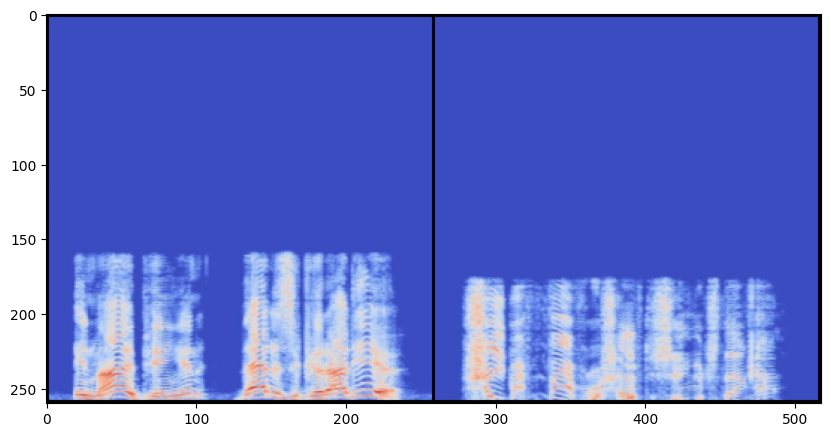

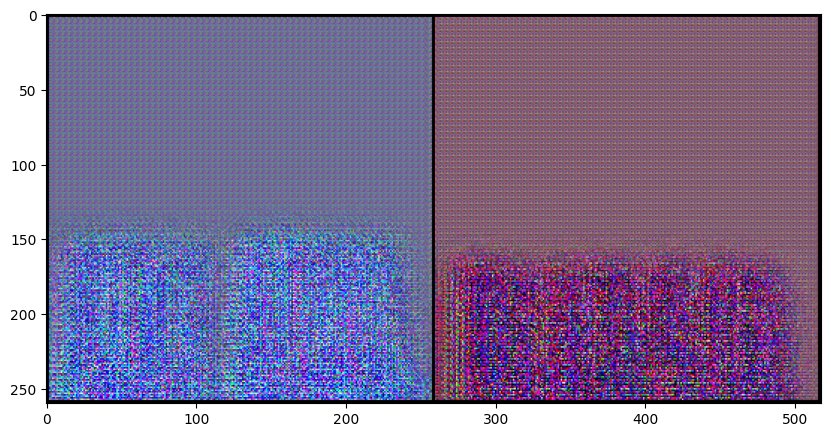

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3: Step 200: Generator (U-Net) loss: 5.8182065451145215, Discriminator loss: 0.2212143256142734


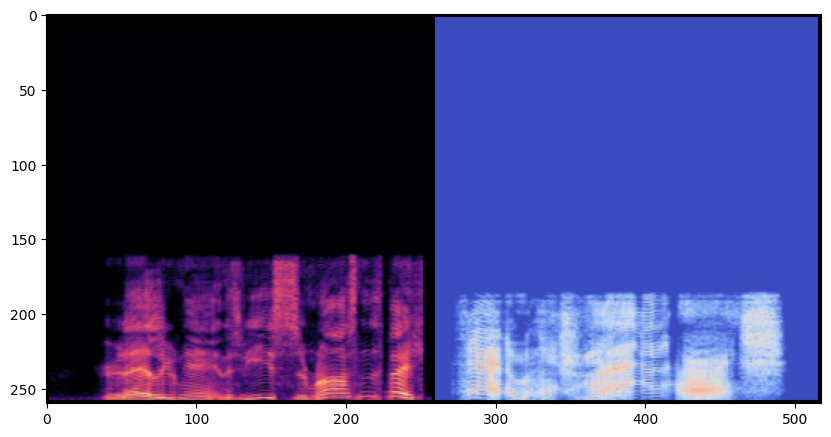

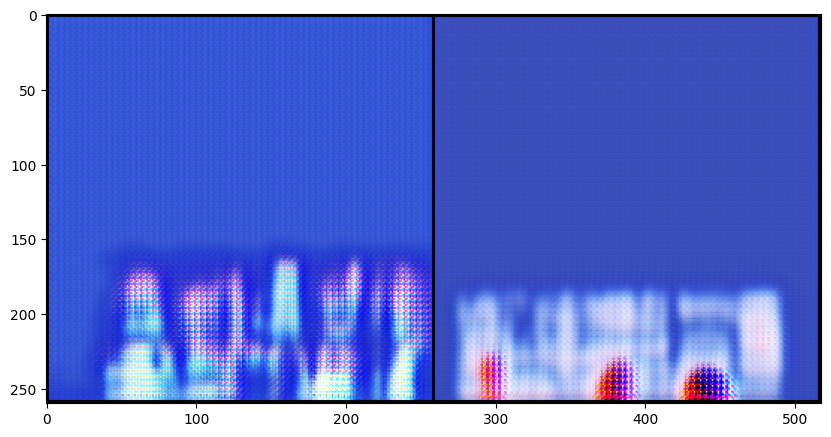

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch 6: Step 400: Generator (U-Net) loss: 5.1802373504638695, Discriminator loss: 0.22694129310548308


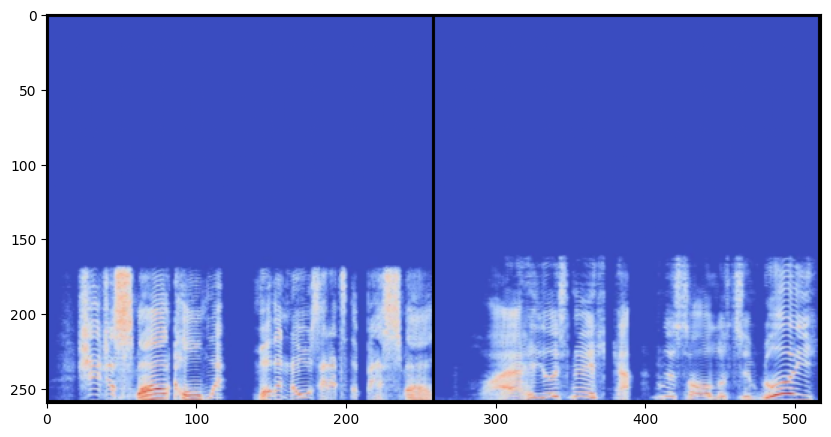

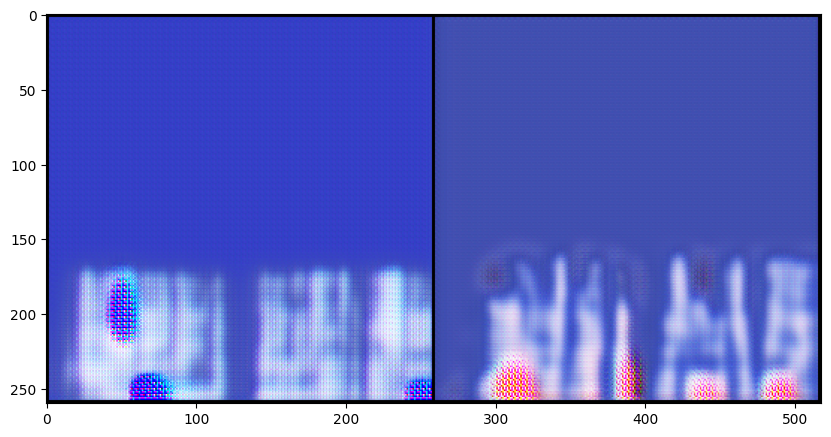

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Epoch 9: Step 600: Generator (U-Net) loss: 3.3988187551498403, Discriminator loss: 0.1898835502006114


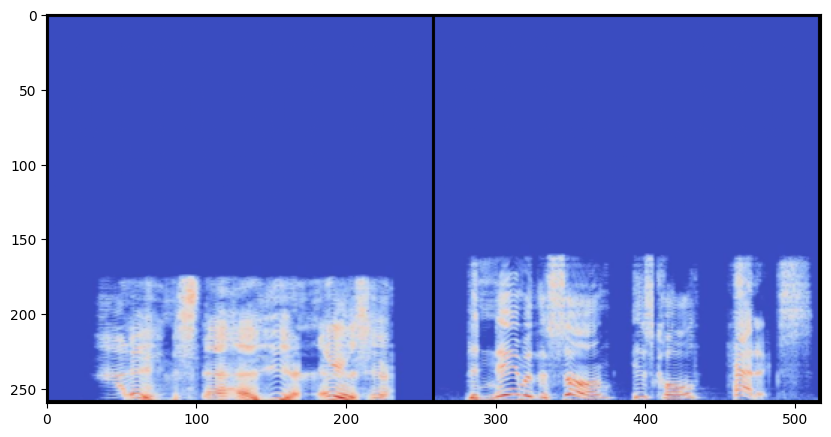

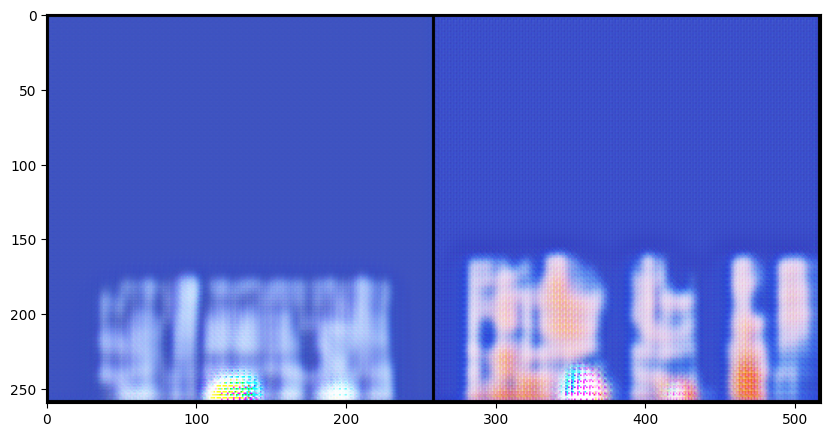

In [54]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)


def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):

        for real_A, real_B in tqdm(dataloader):
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            disc_A_opt.step()

            disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True)
            disc_B_opt.step()

            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()
            gen_opt.step()

            mean_discriminator_loss += disc_A_loss.item() / display_step
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")
            cur_step += 1
train()